In [1]:
import numpy as np
import pandas as pd

# import visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker as lm #downloaded from http://github.com/jbkinney/logomaker

#add the package search path for MAGGIE
import sys
sys.path.append('..')

# import MAGGIE
from maggie import score, utils

# Extract sequences around QTLs
Given a file with QTLs ("dsQTL_info.tsv"), the first step is to obtain sequences (200-bp) around the positions of SNPs. Several tools are able to do this, including but not limited to "bedtools getfasta", "homerTools extract", etc.

# Label sequences as "positive" or "negative"
Positive - alleles associated with a higher level of traits;
Negative - the other alleles associated with a lower level of traits

In [2]:
# read sequences and QTL information
seqs = pd.read_csv('../data/QTL/DNase/dsQTL_referenceAllele.fa', sep='\t', header=None, index_col=0)
qtl_df = pd.read_csv('../data/QTL/DNase/dsQTL_info.tsv', sep='\t', index_col=0)

# lists to store positive and negative sequences
high_seqs = []
low_seqs = []
# list to store SNPs
indices = []
# iterate through each SNP
for snp in seqs.index.values:
    chrom = snp.split('.')[0]
    pos = snp.split('.')[1]
    seq = seqs.loc[snp,1].upper()
    ref_allele = qtl_df.loc[snp, 'ref']
    # sanity check of the reference allele
    if str(ref_allele) == 'nan':
        continue
    if ref_allele != seq[len(seq)//2-1:len(seq)//2-1+len(ref_allele)]:
        print('Error at', snp)
        continue
    indices.append(snp)
    # switch reference allele to alternative allele
    alt = seq[:len(seq)//2-1]+qtl_df.loc[snp, 'alt']+seq[len(seq)//2:]
    # get direction of QTL
    t_val = qtl_df.loc[snp, 't value']
    if t_val > 0: # alternative allele associated with a high level of trait
        high_seqs.append(alt)
        low_seqs.append(seq)
    else: # reference allele associated with a high level of trait
        high_seqs.append(seq)
        low_seqs.append(alt)
seq_df = pd.DataFrame(index=indices, columns=['high_seq', 'low_seq'])
seq_df['high_seq'] = high_seqs
seq_df['low_seq'] = low_seqs

# save sequences
# utils.write_fasta(dict(seq_df['high_seq']), '../data/QTL/DNase/dsQTL_high.fa')
# utils.write_fasta(dict(seq_df['low_seq']), '../data/QTL/DNase/dsQTL_low.fa')

# Load data

In [3]:
# file paths that store positive and negative sequences
pos_seq_file = '../data/QTL/DNase/dsQTL_high.fa'
neg_seq_file = '../data/QTL/DNase/dsQTL_low.fa'

# read sequences as Biopython "Seq" into a dictionary
pos_seq_dict = utils.read_fasta(pos_seq_file)
neg_seq_dict = utils.read_fasta(neg_seq_file)

# read motif files and store in a dictionary
motif_dict = score.load_motifs('../data/JASPAR2020_CORE_vertebrates_motifs/')
print('Loaded %d motifs' % (len(motif_dict)))

Loaded 1011 motifs


# Compute and test for a specific motif
Go to JASPAR database to look for the name and ID of your motif: http://jaspar.genereg.net/

Motif with the same name can have multiple versions, distinguished by their motif IDs

In [4]:
# search for the key of some motif in the loaded motifs
motif_name = 'SPI1'
[k for k in motif_dict if motif_name in k]

['SPI1$MA0080.5', 'SPI1$MA0080.1', 'SPI1$MA0080.4', 'SPI1$MA0080.2']

/gpfs/data01/glasslab/home/zes017/.conda/envs/maggie/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


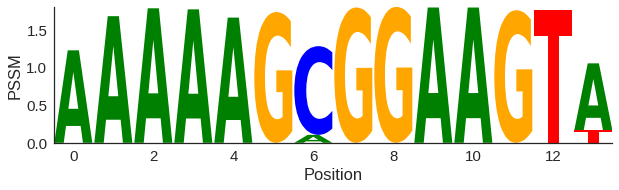

In [5]:
# visualize the PWM logo of a motif using "logomaker" package (Tareen and Kinney, Bioinformatics, 2019)
display_motif = 'SPI1$MA0080.4'
display_df = pd.DataFrame(motif_dict[display_motif].pssm)
display_df = display_df[['A', 'C', 'G', 'T']]
display_df.index.name = 'pos'
display_df = display_df*(display_df>0)

sns.set(style='white', font_scale=1.5, rc={'figure.figsize':(12,8)})
logo = lm.Logo(df=display_df,
               font_name='Arial Rounded MT Bold',
               fade_below=0.8,
               shade_below=0.1)
sns.despine(top=True)
logo.ax.set_xlabel('Position')
logo.ax.set_ylabel('PSSM');

In [6]:
# compute motif score differences for one motif
motif_key = 'SPI1$MA0080.4'
name, ID, statistics, pvals, score_diffs = score.test_one_motif(motif_dict[motif_key], pos_seq_dict, neg_seq_dict)
print('Signed -log10(p-value) for %s-%s is: %.2f' % (name, ID, pvals[0]))

Signed -log10(p-value) for SPI1-MA0080.4 is: 4.63


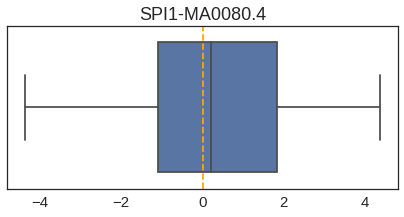

In [7]:
# plot distribution for non-zero differences
score_diffs = np.array(score_diffs)
sns.set(style='white', font_scale=1.5, rc={'figure.figsize':(7,3)})
sns.boxplot(score_diffs[score_diffs!=0])
plt.axvline(0, linestyle='--', c='orange')
plt.title(name+'-'+ID);

It is also possible to extract motif scores for input sequences:

In [8]:
# compute motif scores for positive and negative sequences
pos_scores = score.compute_scores(motif_dict[motif_key], pos_seq_dict)
neg_scores = score.compute_scores(motif_dict[motif_key], neg_seq_dict)
# convert to numpy arrays
pos_scores = np.array(pos_scores)
neg_scores = np.array(neg_scores)

/gpfs/data01/glasslab/home/zes017/.conda/envs/maggie/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


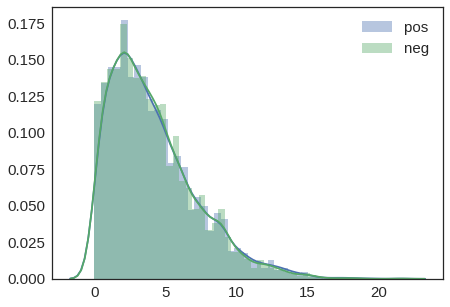

In [9]:
sns.set(style='white', font_scale=1.5, rc={'figure.figsize':(7,5)})
sns.distplot(pos_scores[pos_scores!=0], label='pos')
sns.distplot(neg_scores[neg_scores!=0], label='neg')
plt.legend();

Distribution of motif scores may not show as obvious difference between positive and negative sequences as score differences.